In [ ]:
!pip install pyod

In [2]:
from scipy.stats import expon
from scipy.stats.distributions import norm
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt


# algorithms
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF

# evaluation

from sklearn.model_selection import train_test_split;
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

#1.1 Exponential Distribution

In [26]:
# generate data and label outliers
def exponential_data_outlier_label( cont_factor):
  lamda = random.randint(2, 10);
  rvs =  expon.rvs(scale=1/lamda , size = 10000);
  df = pd.DataFrame(rvs, columns=["Value"]);
  #df['cdf'] = df['Value'].apply(lambda x: expon.cdf(x, scale = 1/lamda));
  # alpha based on cdf
  threshold = expon.ppf( (1- cont_factor), scale = 1/lamda)
  #alpha_inv = 1-alpha;
  print("threshold", threshold)

  df['Label'] = np.where(df['Value'] < threshold, 0, 1);

  in_dst = df.loc[df['Label'] == 0]
  out_dst = df.loc[df['Label'] == 1]
  print("Inlier percent", len(in_dst)/len(df))
  print("Outlier percent", len(out_dst)/len(df))
  print("///////////////////////////////")

  #df = df.drop('cdf', axis=1)
  #df.sort_values('Value')
  return df;



In [27]:
threshold = expon.ppf( (1- 0.02), scale = 1/5)

In [28]:
threshold

0.782404601085629

In [29]:
df = exponential_data_outlier_label(0.05)

threshold 0.7489330683884975
Inlier percent 0.9519
Outlier percent 0.0481
///////////////////////////////


In [30]:
in_dst = df.loc[df['Label'] == 0]
out_dst = df.loc[df['Label'] == 1]

In [ ]:
in_dst

In [32]:
len(in_dst)/len(df)

0.9519

In [33]:
len(out_dst)/len(df)

0.0481

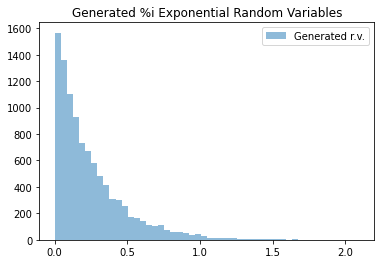

In [34]:
plt.figure()
plt.hist(df["Value"], bins=50, alpha=0.5, label="Generated r.v.")
#plt.plot( df["Value"] ,df["cdf"] )
  #plt.hist(actual, bins=50, alpha=0.5, label="Actual r.v.")
plt.title("Generated %i Exponential Random Variables")
plt.legend()
plt.show()

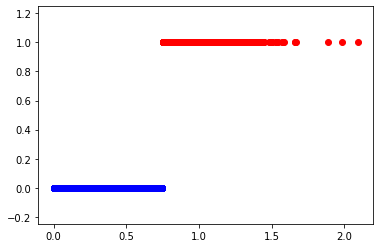

In [35]:
in_dst = df.loc[df['Label'] == 0]
out_dst = df.loc[df['Label'] == 1]
plt.scatter(in_dst['Value'], in_dst['Label'], c ="blue")
plt.scatter(out_dst['Value'], out_dst['Label'], c ="red")
plt.axis('equal')
plt.show()

In [36]:
def label_expon_outliers(cont ,df_input, lamda):
  lamda = lamda
  rvs =  expon.rvs(scale=1/lamda , size = 10000);
  df =pd.DataFrame(df_input, columns=["Value"]);
  #df['cdf'] = df['Value'].apply(lambda x: expon.cdf(x, scale = 1/lamda));
  # alpha based on cdf
  threshold = expon.ppf( (1- cont), scale = 1/lamda)
  #alpha_inv = 1-alpha;
  print("threshold", threshold)

  df['Label'] = np.where(df['Value'] < threshold, 0, 1);

  in_dst = df.loc[df['Label'] == 0]
  out_dst = df.loc[df['Label'] == 1]
  print("Inlier percent", len(in_dst)/len(df))
  print("Outlier percent", len(out_dst)/len(df))
  print("///////////////////////////////")

  #df = df.drop('cdf', axis=1)
  #df.sort_values('Value')
  return df;


In [37]:
X = expon.rvs(scale=1/5 , size = 100000);
df = label_expon_outliers( 0.05 , X, 5);#

threshold 0.599146454710798
Inlier percent 0.94984
Outlier percent 0.05016
///////////////////////////////


In [11]:
cont_factor = np.arange(0.02,0.12,0.02)

In [16]:
def split_data(df):
  X = df.loc[:, df.columns != "Label"]
  y= df["Label"]
  x_train , x_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.30)
  return x_train , x_test, y_train, y_test

In [17]:
def apply_anomaly_detection(x_train ,  x_test , clf):
  clf.fit(x_train.values)
  y_train_pred = clf.predict(x_train.values)
  y_test_pred = clf.predict(x_test.values) 
  #print('a')
  return y_train_pred,y_test_pred

In [18]:
def train_test_eval( y_train, y_test,y_train_pred,y_test_pred ):
  tr_prec = precision_score(y_train, y_train_pred, average='weighted')
  tr_rec = recall_score(y_train, y_train_pred, average='weighted')
  tr_acc = accuracy_score(y_train, y_train_pred, normalize=True);
  tr_f1 = f1_score(y_train, y_train_pred, average='weighted')

  tst_prec = precision_score(y_test, y_test_pred, average='weighted')
  tst_rec = recall_score(y_test, y_test_pred, average='weighted')
  tst_acc = accuracy_score(y_test, y_test_pred, normalize=True);
  tst_f1 = f1_score(y_test, y_test_pred, average='weighted')

  return tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1
  

In [9]:
col_list =[]
met = ['Pr', 'Re', 'Ac', 'F1']
for j in met:
  col_list.append("Tr_"+j)
  col_list.append("Te_"+j)
col_list

['Tr_Pr', 'Te_Pr', 'Tr_Re', 'Te_Re', 'Tr_Ac', 'Te_Ac', 'Tr_F1', 'Te_F1']

In [12]:
df_name_lst = []
for i in cont_factor:
  df_name = "Eval_"+str(round(i,2));
  df_name_lst.append(df_name);
print(df_name_lst)


['Eval_0.02', 'Eval_0.04', 'Eval_0.06', 'Eval_0.08', 'Eval_0.1']


# 1. Exponential Distribution

## 1.1 Exponential + LOF

In [ ]:
df_dict_LOF = { name : pd.DataFrame(columns = col_list) for name in df_name_lst}

In [ ]:
for i in cont_factor:
  #key_name = 'Tr_'+ str(i) +"_"
  lst_name = str(i)+"_lst"
  lst_name = []
  lamda = random.randint(2, 10);
  clf = LOF(contamination = i);
  for j in range(100):
    print("i & j ", i,j)
    temp_lst = []
    X = expon.rvs(scale=1/lamda , size = 100000);
    df = label_expon_outliers( i , X, lamda);#label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(df);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_"+str(round(i,2))
  df_dict_LOF[df_name]= pd.DataFrame(lst_name, columns=col_list)


In [ ]:
# Enumerate over he datafrmes in dictionary and store in excel files
for key in df_dict_LOF:
  sheet_name = "Cont_Fact_LOF_"+key;
  df = df_dict_LOF[key];
  #print(df)
  # write to excel 
  filename = "Cont_Fact_LOF_"+sheet_name+".xlsx";
  df.to_excel(filename, sheet_name=key)

In [ ]:
df_dict_LOF['Eval_0.02']

In [ ]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
var_result_cols = ['cont_fact', 'Train_Pr_var', 'Test_Pr_var', 'Train_Re_var', 'Test_Re_var', 'Train_Acc_var', 'Test_Acc_var', 'Train_F1_var','Test_F1_var'];
lof_cont_results_mean = pd.DataFrame(columns = mu_result_cols)
lof_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [ ]:
for val in df_dict_LOF.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    

lof_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [ ]:
lof_cont_results_mean

In [ ]:
plt.title("lof_cont_results_mean")
plt.plot(lof_cont_results_mean['cont_fact'], lof_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_pr.png', bbox_inches='tight')
plt.show()

plt.title("lof_cont_results_mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_re.png', bbox_inches='tight')
plt.show()


plt.title("lof_cont_results_mean")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_acc.png', bbox_inches='tight')
plt.show()


plt.title("lof_cont_results_mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_f1.png', bbox_inches='tight')
plt.show()

## 1.2 Exponential + OCSVM

In [44]:
df_dict_OCSVM = { name : pd.DataFrame(columns = col_list) for name in df_name_lst}

In [45]:
for i in cont_factor:
  #key_name = 'Tr_'+ str(i) +"_"
  lst_name = str(i)+"_lst"
  lst_name = []
  lamda = random.randint(2, 10);
  clf = OCSVM(contamination = i);
  for j in range(100):
    print("i & j ", i,j)
    temp_lst = []
    X = expon.rvs(scale=1/lamda , size = 10000);
    df = label_expon_outliers( i , X, lamda);#label_gaussian_outliers_new( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(df);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    lst_name.append(temp_lst)

  df_name = "Eval_"+str(round(i,2))
  df_dict_OCSVM[df_name]= pd.DataFrame(lst_name, columns=col_list)


i & j  0.02 0
threshold 1.3040076684760482
Inlier percent 0.9812
Outlier percent 0.0188
///////////////////////////////
i & j  0.02 1
threshold 1.3040076684760482
Inlier percent 0.9811
Outlier percent 0.0189
///////////////////////////////
i & j  0.02 2
threshold 1.3040076684760482
Inlier percent 0.9806
Outlier percent 0.0194
///////////////////////////////
i & j  0.02 3
threshold 1.3040076684760482
Inlier percent 0.9809
Outlier percent 0.0191
///////////////////////////////
i & j  0.02 4
threshold 1.3040076684760482
Inlier percent 0.9787
Outlier percent 0.0213
///////////////////////////////
i & j  0.02 5
threshold 1.3040076684760482
Inlier percent 0.9799
Outlier percent 0.0201
///////////////////////////////
i & j  0.02 6
threshold 1.3040076684760482
Inlier percent 0.9788
Outlier percent 0.0212
///////////////////////////////
i & j  0.02 7
threshold 1.3040076684760482
Inlier percent 0.9811
Outlier percent 0.0189
///////////////////////////////
i & j  0.02 8
threshold 1.30400766847604

In [51]:
# Enumerate over he datafrmes in dictionary and store in excel files
for key in df_dict_OCSVM:
  sheet_name = "Cont_Fact_OCSVM_"+key;
  df = df_dict_OCSVM[key];
  #print(df)
  # write to excel 
  filename = "Cont_Fact_OCSVM_"+sheet_name+".xlsx";
  df.to_excel(filename, sheet_name=key)

In [ ]:
df_dict_OCSVM['Eval_0.02']

In [48]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
var_result_cols = ['cont_fact', 'Train_Pr_var', 'Test_Pr_var', 'Train_Re_var', 'Test_Re_var', 'Train_Acc_var', 'Test_Acc_var', 'Train_F1_var','Test_F1_var'];
ocsvm_cont_results_mean = pd.DataFrame(columns = mu_result_cols)
ocsvm_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [49]:
for val in df_dict_OCSVM.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    

ocsvm_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

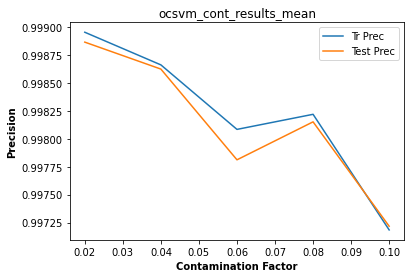

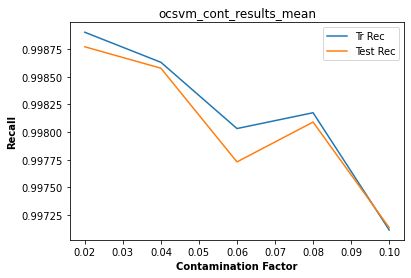

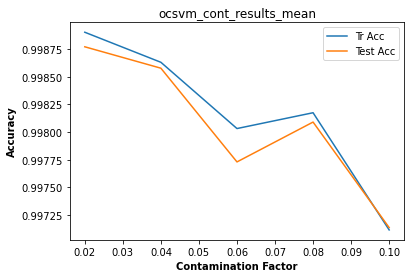

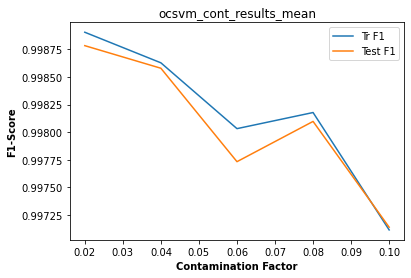

In [50]:
plt.title("ocsvm_cont_results_mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'], ocsvm_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('ocsvm_cont_results_mean_pr.png', bbox_inches='tight')
plt.show()

plt.title("ocsvm_cont_results_mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('ocsvm_cont_results_mean_re.png', bbox_inches='tight')
plt.show()


plt.title("ocsvm_cont_results_mean")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('ocsvm_cont_results_mean_acc.png', bbox_inches='tight')
plt.show()


plt.title("ocsvm_cont_results_mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('ocsvm_cont_results_mean_f1.png', bbox_inches='tight')
plt.show()

# 2. Normal Distribution

In [19]:
def label_gaussian_outliers( cont , df_input , mu_input, std_input):
  print("Gaussian")
  mu = mu_input
  std = std_input
  rvs =  norm.rvs(loc=mu, scale=std, size=10000, random_state=None)
  df =pd.DataFrame(df_input, columns=["Value"]);
  #df['cdf'] = df['Value'].apply(lambda x: expon.cdf(x, scale = 1/lamda));
  # alpha based on cdf
  threshold_1 = norm.ppf( (1-(cont/2)) , loc= mu, scale = std)
  #alpha_inv = 1-alpha;
  print("threshold_1", threshold_1)
  #df['Label'] = np.where( (df['Value'] > threshold_1), 1,0);


  threshold_2 = norm.ppf( (cont/2), loc= mu, scale = std)
  print("threshold_2", threshold_2)
  df['Label'] = np.where(((df['Value'] < threshold_2) | (df['Value']> threshold_1) ), 1, 0);
  #df['Label'] = np.where((df['Value'] > threshold_2 ), 0, 1);

  #df.loc[df[''] <= 53, '<= 53'] = 'True'
  #df.loc[df['mynumbers'] > 53, '<= 53'] = 'False'
  #i = 0;
  #for index, row in df.iterrows():
  #  if(row['Value']> threshold_1 or row['Value']< threshold_2):
  #    df['Label']=1
  #  else:
  #    df['Label']=0
    #print(i+1)
    #i=i+1; 

  in_dst = df.loc[df['Label'] == 0]
  out_dst = df.loc[df['Label'] == 1]
  print("Inlier percent", len(in_dst)/len(df))
  print("Outlier percent", len(out_dst)/len(df))
  print("///////////////////////////////")

  #df = df.drop('cdf', axis=1)
  #df.sort_values('Value')
  return df;


## 2.1 Normal + LOF

In [64]:
df_dict_LOF = { name : pd.DataFrame(columns = col_list) for name in df_name_lst}

In [ ]:
for i in cont_factor:
  #key_name = 'Tr_'+ str(i) +"_"
  lst_name = str(i)+"_lst"
  lst_name = []
  mu = random.randint(2, 10);
  std = random.randint(1 , 30);
  clf = OCSVM(contamination = i);
  for j in range(100):
    print("i & j ", i,j)
    temp_lst = []
    X = norm.rvs(loc=mu, scale=std,size=10000);
    df = label_gaussian_outliers( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(df);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    #in_dst = df.loc[df['Label'] == 0]
    #out_dst = df.loc[df['Label'] == 1]
    #plt.scatter(in_dst['val'], in_dst['pdf'], c ="blue")
    #plt.scatter(out_dst['val'], out_dst['pdf'], c ="red")
    #plt.axis('equal')
    #plt.show()
    

    lst_name.append(temp_lst)

  df_name = "Eval_"+str(round(i,2))
  df_dict_LOF[df_name]= pd.DataFrame(lst_name, columns=col_list)


In [68]:
# Enumerate over he datafrmes in dictionary and store in excel files
for key in df_dict_LOF:
  sheet_name = "Cont_Fact_LOF_"+key;
  df = df_dict_LOF[key];
  #print(df) 
  # write to excel   
  filename = "Cont_Fact_LOF_"+sheet_name+".xlsx";
  df.to_excel(filename, sheet_name=key)

In [ ]:
df_dict_LOF['Eval_0.02']

In [70]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
var_result_cols = ['cont_fact', 'Train_Pr_var', 'Test_Pr_var', 'Train_Re_var', 'Test_Re_var', 'Train_Acc_var', 'Test_Acc_var', 'Train_F1_var','Test_F1_var'];
lof_cont_results_mean = pd.DataFrame(columns = mu_result_cols)
lof_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [71]:
for val in df_dict_LOF.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    

lof_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [ ]:
lof_cont_results_mean

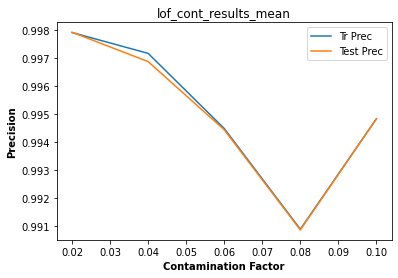

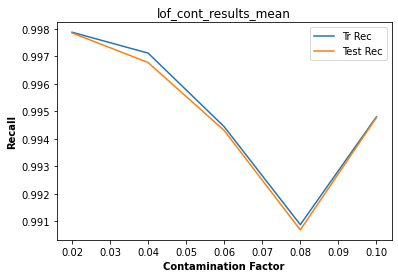

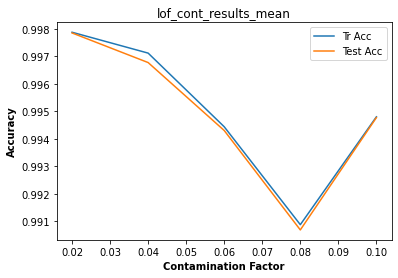

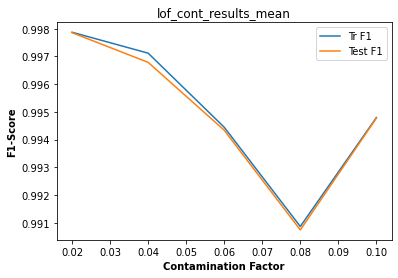

In [73]:
plt.title("lof_cont_results_mean")
plt.plot(lof_cont_results_mean['cont_fact'], lof_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_pr.png', bbox_inches='tight')
plt.show()

plt.title("lof_cont_results_mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_re.png', bbox_inches='tight')
plt.show()


plt.title("lof_cont_results_mean")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_acc.png', bbox_inches='tight')
plt.show()


plt.title("lof_cont_results_mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_f1.png', bbox_inches='tight')
plt.show()

## 2.2 Normal+OCSVM

In [14]:
df_dict_LOF = { name : pd.DataFrame(columns = col_list) for name in df_name_lst}

In [21]:
for i in cont_factor:
  #key_name = 'Tr_'+ str(i) +"_"
  lst_name = str(i)+"_lst"
  lst_name = []
  mu = random.randint(2, 10);
  std = random.randint(1 , 30);
  clf = LOF(contamination = i);
  for j in range(100):
    print("i & j ", i,j)
    temp_lst = []
    X = norm.rvs(loc=mu, scale=std,size=100000);
    df = label_gaussian_outliers( i , X , mu, std);
    x_train , x_test, y_train, y_test = split_data(df);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    
    #in_dst = df.loc[df['Label'] == 0]
    #out_dst = df.loc[df['Label'] == 1]
    #plt.scatter(in_dst['val'], in_dst['pdf'], c ="blue")
    #plt.scatter(out_dst['val'], out_dst['pdf'], c ="red")
    #plt.axis('equal')
    #plt.show()
    

    lst_name.append(temp_lst)

  df_name = "Eval_"+str(round(i,2))
  df_dict_LOF[df_name]= pd.DataFrame(lst_name, columns=col_list)


i & j  0.02 0
Gaussian
threshold_1 78.79043622122522
threshold_2 -60.79043622122522
Inlier percent 0.9794
Outlier percent 0.0206
///////////////////////////////
i & j  0.02 1
Gaussian
threshold_1 78.79043622122522
threshold_2 -60.79043622122522
Inlier percent 0.97956
Outlier percent 0.02044
///////////////////////////////
i & j  0.02 2
Gaussian
threshold_1 78.79043622122522
threshold_2 -60.79043622122522
Inlier percent 0.97994
Outlier percent 0.02006
///////////////////////////////
i & j  0.02 3
Gaussian
threshold_1 78.79043622122522
threshold_2 -60.79043622122522
Inlier percent 0.98013
Outlier percent 0.01987
///////////////////////////////
i & j  0.02 4
Gaussian
threshold_1 78.79043622122522
threshold_2 -60.79043622122522
Inlier percent 0.97973
Outlier percent 0.02027
///////////////////////////////
i & j  0.02 5
Gaussian
threshold_1 78.79043622122522
threshold_2 -60.79043622122522
Inlier percent 0.97958
Outlier percent 0.02042
///////////////////////////////
i & j  0.02 6
Gaussian
t

In [22]:
# Enumerate over he datafrmes in dictionary and store in excel files
for key in df_dict_LOF:
  sheet_name = "Cont_Fact_LOF_"+key;
  df = df_dict_LOF[key];
  #print(df) 
  # write to excel   
  filename = "Cont_Fact_LOF_"+sheet_name+".xlsx";
  df.to_excel(filename, sheet_name=key)

In [ ]:
df_dict_LOF['Eval_0.02']

In [24]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
var_result_cols = ['cont_fact', 'Train_Pr_var', 'Test_Pr_var', 'Train_Re_var', 'Test_Re_var', 'Train_Acc_var', 'Test_Acc_var', 'Train_F1_var','Test_F1_var'];
lof_cont_results_mean = pd.DataFrame(columns = mu_result_cols)
lof_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [25]:
for val in df_dict_LOF.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    

lof_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [26]:
lof_cont_results_mean

,cont_fact,Train_Pr_mu,Test_Pr_mu,Train_Re_mu,Test_Re_mu,Train_Acc_mu,Test_Acc_mu,Train_F1_mu,Test_F1_mu
0,0.02,0.961978,0.961819,0.967611,0.956887,0.967611,0.956887,0.964755,0.959332
1,0.04,0.924100,0.923828,0.934033,0.914080,0.934033,0.914080,0.928986,0.918892
2,0.06,0.889060,0.888845,0.901844,0.873673,0.901844,0.873673,0.895320,0.881104
3,0.08,0.854255,0.854050,0.869722,0.835229,0.869722,0.835229,0.861792,0.844386
4,0.10,0.821613,0.821651,0.838898,0.798968,0.838898,0.798968,0.829991,0.809908


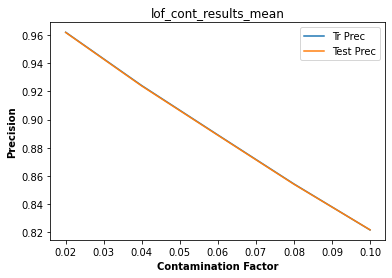

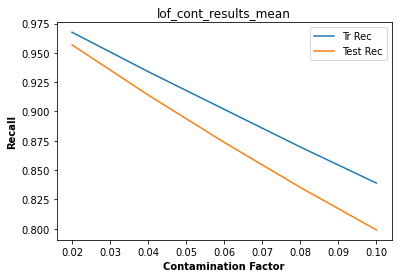

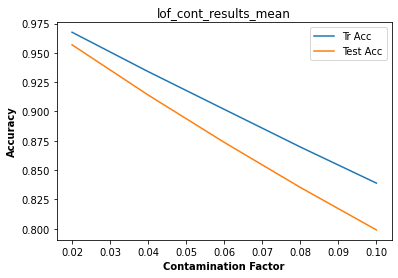

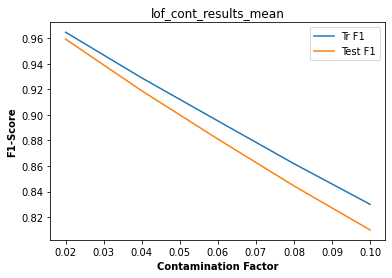

In [27]:
plt.title("lof_cont_results_mean")
plt.plot(lof_cont_results_mean['cont_fact'], lof_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_pr.png', bbox_inches='tight')
plt.show()

plt.title("lof_cont_results_mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_re.png', bbox_inches='tight')
plt.show()


plt.title("lof_cont_results_mean")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_acc.png', bbox_inches='tight')
plt.show()


plt.title("lof_cont_results_mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_f1.png', bbox_inches='tight')
plt.show()

# Compare Algorithms